In [4]:
# ! conda install -c conda-forge ta --yes

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\George\anaconda3

  added / updated specs:
    - ta


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    conda-22.11.1              |   py39hcbf5309_1         908 KB  conda-forge
    python_abi-3.9             |           2_cp39           4 KB  conda-forge
    ruamel.yaml-0.17.21        |   py39hb82d6ee_1         169 KB  conda-forge
    ruamel.yaml.clib-0.2.6     |   py39h2bbff1b_1         101 KB
    ta-0.10.2                  |     pyhd8ed1ab_0         1.6 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.7 MB

The following NEW packages will be INSTALLED:

  python_abi         conda-forge/win-64::python_abi-3.9-2_cp39 None
  ruamel.yaml        conda-forge/win-64::ruamel.yaml-0.17.21-py39hb82d6ee_1 None
  ru



==> WARNING: A newer version of conda exists. <==
  current version: 22.9.0
  latest version: 23.1.0

Please update conda by running

    $ conda update -n base -c defaults conda




==> WARNING: A newer version of conda exists. <==
  current version: 22.9.0
  latest version: 23.1.0

Please update conda by running

    $ conda update -n base -c defaults conda




Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\George\anaconda3

  added / updated specs:
    - ta


The following NEW packages will be INSTALLED:

  python_abi         conda-forge/win-64::python_abi-3.9-2_cp39 None
  ruamel.yaml        conda-forge/win-64::ruamel.yaml-0.17.21-py39hb82d6ee_1 None
  ruamel.yaml.clib   pkgs/main/win-64::ruamel.yaml.clib-0.2.6-py39h2bbff1b_1 None
  ta                 conda-forge/noarch::ta-0.10.2-pyhd8ed1ab_0 None

The following packages will be UPDATED:

  conda              pkgs/main::conda-22.9.0-py39haa95532_0 --> conda-forge::conda-22.11.1-py39hcbf5309_1 None


Preparing transaction: ...working... done
Verifying transaction: ...working... done
Executing transaction: ...working... done
Retrieving notices: ...working... done
Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\George\anaconda3

  added / updated specs:
    - ta


The following NEW packages will be IN



==> WARNING: A newer version of conda exists. <==
  current version: 22.9.0
  latest version: 23.1.0

Please update conda by running

    $ conda update -n base -c defaults conda




In [3]:
import websocket
import requests
import json
import pandas as pd
import ta
import matplotlib.pyplot as plt
import math
import pytz

In [4]:
timezone = 8
endpoint = 'wss://stream.binance.com:9443/ws'
symbol = 'ethusdt'
symbol_C = symbol.upper()
rate = 30
interval = '15m'
limit = 200

In [5]:
data = json.dumps({'method':'SUBSCRIBE','params':[symbol + '@kline_' + interval],'id':1})
df = pd.DataFrame()

In [6]:
def get_historical(symbol, interval, limit):
    url = "https://api.binance.com/api/v3/klines"
    params = {"symbol": symbol_C,
              "interval": interval,
              "limit": limit}
    response = requests.get(url, params=params).json()
    df = pd.DataFrame(response, columns = ["Open time", "Open", "High", "Low", "Close",
                                           "Volume", "Close_Time", "Quote asset volume",
                                           "Number of trades", "Taker buy base asset volume",
                                           "Taker buy quote asset volume", "Ignore"])
    df = df[['Close_Time', 'Open', 'Close', "High", "Low", 'Volume']]
    convert_dict = {'Close_Time': float, 'Open': float, 'Close': float, "High": float, "Low": float, 'Volume': float}
    df = df.astype(convert_dict)
    return df

In [7]:
df = get_historical(symbol, interval, limit)
df['Close_Time'] = pd.to_datetime(df['Close_Time'], unit = 'ms')
# df.drop(['Close_Time'], axis =1, inplace=True)
df['Closed'] = True

print(df)

                       Close_Time     Open    Close     High      Low  \
0   2023-02-12 13:29:59.999000064  1527.38  1524.48  1528.55  1522.73   
1   2023-02-12 13:44:59.999000064  1524.48  1524.19  1525.67  1521.43   
2   2023-02-12 13:59:59.999000064  1524.19  1526.26  1527.00  1524.18   
3   2023-02-12 14:14:59.999000064  1526.27  1525.90  1526.66  1525.90   
4   2023-02-12 14:29:59.999000064  1525.91  1527.70  1528.16  1524.67   
..                            ...      ...      ...      ...      ...   
195 2023-02-14 14:14:59.999000064  1514.48  1505.60  1517.49  1502.64   
196 2023-02-14 14:29:59.999000064  1505.60  1500.80  1510.48  1499.02   
197 2023-02-14 14:44:59.999000064  1500.79  1511.58  1514.00  1495.61   
198 2023-02-14 14:59:59.999000064  1511.59  1554.76  1563.99  1511.58   
199 2023-02-14 15:14:59.999000064  1554.76  1554.15  1559.99  1554.09   

         Volume  Closed  
0     3370.3360    True  
1     3221.2165    True  
2     1925.4713    True  
3     1221.2535    

In [8]:
def on_open(ws):
    ws.send(data)

def on_message(ws, message):
    global df, rate, limit
    out = json.loads(message)    
    out = pd.DataFrame({'Close_Time':pd.to_datetime(out['E'], unit = 'ms') + pd.Timedelta(hours=timezone),
                        'Open':float(out['k']['o']),
                        'Close':float(out['k']['c']),
                        'High':float(out['k']['h']),
                        'Low':float(out['k']['l']),
                        'Volume':float(out['k']['v']),
                        'Closed':bool(out['k']['x'])},
                        index=[pd.to_datetime(out['E'], unit = 'ms')])
    
    out['Close_Time'] = out['Close_Time'].dt.strftime('%Y-%m-%d %H:%M:%S')

    # out['Sma'] = sma.tail(1)[0]
    # out['Bb_U'] = bband_up.tail(1)[0]
    # out['Bb_D'] = bband_down.tail(1)[0]
    df = pd.concat([df,out], axis = 0)


    
    print(df)
    # df = df.tail(5)
    # df.drop(df[df['closed'] == False].index, axis=0, inplace=True)



In [9]:
ws = websocket.WebSocketApp(endpoint, on_message = on_message, on_open = on_open)
ws.run_forever()

False

In [106]:
def indicators(df):
#     sma
    sma_int = 30
    df['sma'] = ta.trend.sma_indicator(df.Close, window=sma_int)
#     bband
    bb_int = 30
    bb_dev = 2
    bb = ta.volatility.BollingerBands(df['Close'], window=bb_int, window_dev=bb_dev)
    df['bb_u'] = bb.bollinger_hband()
    df['bb_m'] = bb.bollinger_mavg()
    df['bb_l'] = bb.bollinger_lband()
#     rsi
    rsi_int = 14
    df['rsi'] = ta.momentum.RSIIndicator(df['Close'], window = rsi_int).rsi()
#     df.dropna(inplace=True)
    return df

In [107]:
indicators(df)

,Close_Time,Open,Close,High,Low,Volume,Closed,sma,bb_u,bb_m,bb_l,rsi
0,2023-02-11 08:14:59.999000064,1520.80,1522.41,1522.41,1519.50,1787.2449,True,NaN,NaN,NaN,NaN,NaN
1,2023-02-11 08:29:59.999000064,1522.40,1519.86,1522.43,1519.64,2102.7878,True,NaN,NaN,NaN,NaN,NaN
2,2023-02-11 08:44:59.999000064,1519.85,1524.76,1526.80,1518.97,15010.2611,True,NaN,NaN,NaN,NaN,NaN
3,2023-02-11 08:59:59.999000064,1524.76,1522.79,1524.93,1520.00,9886.2160,True,NaN,NaN,NaN,NaN,NaN
4,2023-02-11 09:14:59.999000064,1522.78,1523.79,1523.80,1521.63,1957.7673,True,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
195,2023-02-13 08:59:59.999000064,1504.54,1506.19,1510.00,1504.37,5587.3313,True,1515.726333,1526.949676,1515.726333,1504.502990,33.990095
196,2023-02-13 09:14:59.999000064,1506.18,1499.38,1510.20,1497.77,16981.3135,True,1515.316000,1527.915392,1515.316000,1502.716608,28.101505
197,2023-02-13 09:29:59.999000064,1499.39,1479.85,1499.48,1472.03,58576.6890,True,1514.410000,1532.130570,1514.410000,1496.689430,18.306509
198,2023-02-13 09:44:59.999000064,1479.84,1484.21,1485.46,1472.73,22713.1084,True,1513.621000,1534.295825,1513.621000,1492.946175,24.623088


In [138]:
# green k
# volume > previous volume 1.5x
# close > previous open
# low < lowerband
for index, row in df.iterrows():
    df['c1'] = df['Volume'] > df['Volume'].shift(1)
    df['c2'] = df['Close'] > df['Open'].shift(1)
    df['c3'] = df['Low'] < df['bb_l']
    df['c4'] = df['Close'] > df['Open']

# set signal to True
df['signal'] = False
df.loc[df.c1 & df.c2 & df.c3 & df.c4, 'signal'] = True

df = df.reset_index(drop=True)

# enter in next candle
df['openbuy'] = False
for i in range(len(df) - 1):
    if df.loc[i, 'signal'] == True:
        df.loc[i + 1, 'openbuy'] = True

# show signal and enter reference
buydf = df[(df['signal'] == True) | (df['openbuy'] == True)]
# set buydf index
buydf = buydf.reset_index(drop=True)


# set entry price (前一根k線一半進場)
# set stop loss (前一根k線低點再往下一個 close - open)
for index, row in df.iterrows():
    if buydf['openbuy'].any() == True:
        buydf['entry_p'] = buydf['Open'].shift(1) + (buydf['Close'].shift(1) - buydf['Open'].shift(1))*0.5
        buydf['stop_loss'] = buydf['Open'].shift(1) - (buydf['Close'].shift(1) - buydf['Open'].shift(1))
        buydf['take_profit'] = 


    
# buydf = df[df['openbuy'] == True]       
print(buydf)


                       Close_Time     Open    Close     High      Low  \
43  2023-02-11 18:59:59.999000064  1513.20  1514.77  1516.46  1512.09   
54  2023-02-11 21:44:59.999000064  1521.77  1525.95  1526.39  1521.09   
55  2023-02-11 21:59:59.999000064  1525.95  1534.41  1537.02  1525.95   
56  2023-02-11 22:14:59.999000064  1534.41  1534.27  1536.62  1530.66   
57  2023-02-11 22:29:59.999000064  1534.27  1535.92  1538.00  1531.39   
58  2023-02-11 22:44:59.999000064  1535.92  1540.29  1542.64  1535.31   
59  2023-02-11 22:59:59.999000064  1540.29  1536.28  1540.30  1535.10   
60  2023-02-11 23:14:59.999000064  1536.27  1539.13  1540.00  1535.25   
61  2023-02-11 23:29:59.999000064  1539.12  1541.60  1543.00  1538.80   
62  2023-02-11 23:44:59.999000064  1541.59  1540.61  1542.01  1538.95   
98  2023-02-12 08:44:59.999000064  1533.19  1535.13  1535.44  1532.79   
99  2023-02-12 08:59:59.999000064  1535.12  1531.47  1535.45  1531.00   
101 2023-02-12 09:29:59.999000064  1534.35  1535.94

                     Close_Time     Open    Close     High      Low  \
0 2023-02-11 17:29:59.999000064  1516.32  1518.25  1518.26  1515.36   
1 2023-02-11 17:44:59.999000064  1518.26  1517.00  1518.26  1515.00   

      Volume  Closed       sma         bb_u      bb_m         bb_l        rsi  \
0  1829.8695    True  1520.310  1524.719701  1520.310  1515.900299  44.913838   
1  3340.1313    True  1520.198  1524.764812  1520.198  1515.631188  42.345031   

     c1    c2    c3     c4  signal  openbuy  entry_p  
0  True  True  True   True    True    False      NaN  
1  True  True  True  False   False     True  1518.25  


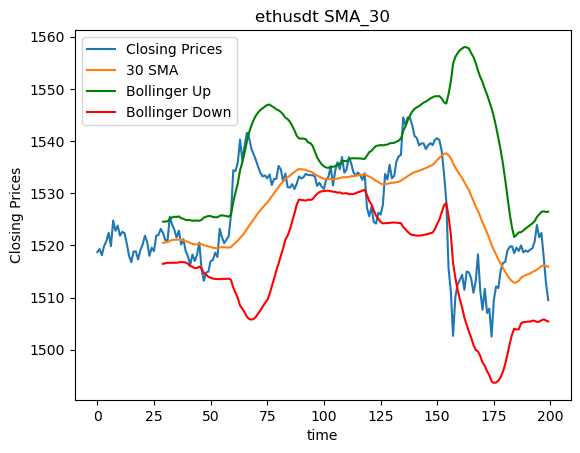

In [66]:
plt.title(symbol + ' SMA_' + str(rate))
plt.xlabel('time')
plt.ylabel('Closing Prices')
plt.plot(df.Close, label='Closing Prices')
plt.plot(df.sma, label= str(rate) + ' SMA')
plt.plot(df.bb_u, label='Bollinger Up', c='g')
plt.plot(df.bb_l, label='Bollinger Down', c='r')
plt.legend()
plt.show()